**CONCLUSION поместить здесь**

# Intro

## About Dataset

**Context**

YouTube (the world-famous video sharing website) maintains a list of the [top trending videos](https://www.youtube.com/feed/trending) on the platform. [According to Variety magazine](http://variety.com/2017/digital/news/youtube-2017-top-trending-videos-music-videos-1202631416/), “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.

This dataset is a daily record of the top trending YouTube videos.

Note that this dataset is a structurally improved version of this [dataset](https://www.kaggle.com/datasnaek/youtube).

**Content**

This dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, and FR regions (USA, Great Britain, Germany, Canada, and France, respectively), with up to 200 listed trending videos per day.

EDIT: Now includes data from RU, MX, KR, JP and IN regions (Russia, Mexico, South Korea, Japan and India respectively) over the same time period.

Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The data also includes a `category_id field`, which varies between regions. To retrieve the categories for a specific video, find it in the associated `JSON`. One such file is included for each of the five regions in the dataset.

For more information on specific columns in the dataset refer to the [column metadata](https://www.kaggle.com/datasnaek/youtube-new/data).

## Questions

Based on https://kaggle.com/datasnaek/youtube-new answer the questions:

1) What are the categorical differences in viewing patterns between Germans and Indians?

2) Ratios between views / likes / dislikes for different categories / countries. It seems to me that the Mexicans like all videos and the British are unhappy again. Is it easier for musicians to collect likes than for politicians?

3) Сhannels that are popular in most countries. Ed Sheeran, hello.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from datetime import datetime
from glob import glob
import pycountry
import json
import time
import datetime
from datetime import date
#import textblob
import itertools
import os
from pathlib2 import Path
from subprocess import check_output
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings("ignore")

# Data load

In [2]:
countries=  ["GB", "MX",  "KR", "DE", "FR", "US", "IN", "RU", "JP", "CA" ]

for file in glob('..\..\data\youtube-new\*.csv'):
    print(file.split('\\')[4][:2], 
          " - ", 
          pycountry.countries.get(alpha_2=file.split('\\')[4][:2]).name)

CA  -  Canada
DE  -  Germany
FR  -  France
GB  -  United Kingdom
IN  -  India
JP  -  Japan
KR  -  Korea, Republic of
MX  -  Mexico
RU  -  Russian Federation
US  -  United States


- Assign country code to each dataframe before combining to generate geography-wise analysis.
- Assign category name to corresponding category id to generate category-wise analysis.
- Generate two functions - One to extract category name and id.
- Other to set category names by using the category id in the dataframe.
- Transform all dates to uniform format of YYYY-MM-DD.
- Get the difference in number of days between published date of video and its trending date.
- Get the length of each description.

In [3]:
#function that extracts category and category id from json string and returns in a dictionary
def get_category_dict(json_string):
    category_dict = {}
    for items in range(len(json_string["items"])):
        category_dict[int(json_string["items"][items]["id"].strip())] = json_string["items"][items]["snippet"]["title"]
    return category_dict

#function that assigns category name to each category id in dataframe
def get_categories(cid_values,category_dict):
    category = []
    for cid in cid_values:
        if cid in category_dict:
            category.append(category_dict[cid])
        else:
            category.append("Other")
    return category

#function that modifies date from YY.DD.MM to YYYY-MM-DD
def transform_date(date_values):
    for item in range(len(date_values)):
        converted_time = time.strptime(date_values[item], '%y.%d.%m')
        date_values[item] = str(converted_time.tm_year) + \
        "-" + \
        str(converted_time.tm_mon) + \
        "-" + \
        str(converted_time.tm_mday)
    return date_values

#function that reuturns the difference in days between publish date and trending date
def get_diff(trending_date,publish_date):
    days = []
    for td,pd in zip(trending_date,publish_date):
        #+1 is added to compensate for the number of videos that were published and became trending on the same day. Else it would
        #have a value of -1
        days.append((datetime.datetime.strptime(td,"%Y-%m-%d") - datetime.datetime.strptime(pd,'%Y-%m-%dT%H:%M:%S.000Z')).days+1)
    return days

In [4]:
# 16 min

df_ = pd.DataFrame()

for country in tqdm(["GB", "MX", "KR", "DE", "FR", "US", "IN", "RU", "JP", "CA"]):

    df = pd.read_csv(f"..\..\data\youtube-new\{country}videos.csv", encoding="latin")
    df_json = json.loads("".join(open(f'..\..\data\youtube-new\{country}_category_id.json',"r").readlines()))
    category_dict = get_category_dict(df_json)
    category = get_categories(df["category_id"].values,category_dict)
    country_code = [f'{country}'] * len(df)
    df["Category"] = category
    df["Country_code"] = country_code
    df["trending_date"] = transform_date(df["trending_date"].values)
    df["days"] = get_diff(df["trending_date"],df["publish_time"])
    
    df_ = pd.concat([df_, df])

df_ = df_.drop(['video_id'],axis=1)
df_

  0%|          | 0/10 [00:00<?, ?it/s]

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Category,Country_code,days
0,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style,GB,4
1,2017-11-14,Taylor Swift: â¦Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs â¦Ready f...,Entertainment,GB,2
2,2017-11-14,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,Music,GB,4
3,2017-11-14,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Sports,GB,1
4,2017-11-14,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,News & Politics,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,2018-6-14,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13T18:00:07.000Z,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,ð¨ NEW MERCH! http://amzn.to/annoyingorange ...,Entertainment,CA,1
40877,2018-6-14,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13T19:01:18.000Z,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,âº Retrouvez vos programmes prÃ©fÃ©rÃ©s : htt...,Entertainment,CA,1
40878,2018-6-14,KINGDOM HEARTS III â SQUARE ENIX E3 SHOWCASE...,Kingdom Hearts,20,2018-06-11T17:30:53.000Z,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...,Gaming,CA,3
40879,2018-6-14,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13T04:00:05.000Z,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isnât talking so tough now. An...,News & Politics,CA,1


In [5]:
df_['trending_date'] = pd.to_datetime(df_['trending_date'], format='%Y-%m-%d')
df_['publish_time'] = pd.to_datetime(df_['publish_time'], format='%Y-%m-%dT%H:%M:%S.%f%z')

In [6]:
# сохраняем
df_.to_pickle('..\..\data\youtube-new\df.pkl')

In [7]:
df = pd.read_pickle('..\..\data\youtube-new\df.pkl')
print(df.shape)
df

(375942, 18)


,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Category,Country_code,days
0,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style,GB,4
1,2017-11-14,Taylor Swift: â¦Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12 06:24:44+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs â¦Ready f...,Entertainment,GB,2
2,2017-11-14,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,Music,GB,4
3,2017-11-14,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13 02:30:38+00:00,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Sports,GB,1
4,2017-11-14,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13 01:45:13+00:00,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,News & Politics,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,2018-06-14,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13 18:00:07+00:00,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,ð¨ NEW MERCH! http://amzn.to/annoyingorange ...,Entertainment,CA,1
40877,2018-06-14,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13 19:01:18+00:00,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,âº Retrouvez vos programmes prÃ©fÃ©rÃ©s : htt...,Entertainment,CA,1
40878,2018-06-14,KINGDOM HEARTS III â SQUARE ENIX E3 SHOWCASE...,Kingdom Hearts,20,2018-06-11 17:30:53+00:00,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...,Gaming,CA,3
40879,2018-06-14,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13 04:00:05+00:00,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isnât talking so tough now. An...,News & Politics,CA,1


# Short data overview

In [8]:
round(df.describe().drop(["category_id"],axis=1), 1)

,views,likes,dislikes,comment_count,days
count,375942.0,375942.0,375942.0,375942.0,375942.0
mean,1326568.3,37884.3,2126.1,4253.8,7.5
std,7098567.7,165413.1,22484.4,25458.8,97.4
min,117.0,0.0,0.0,0.0,0.0
25%,46978.0,669.0,41.0,109.0,1.0
50%,177370.5,3446.0,179.0,511.0,1.0
75%,647679.2,17476.5,749.0,2011.0,3.0
max,424538912.0,5613827.0,1944971.0,1626501.0,4215.0


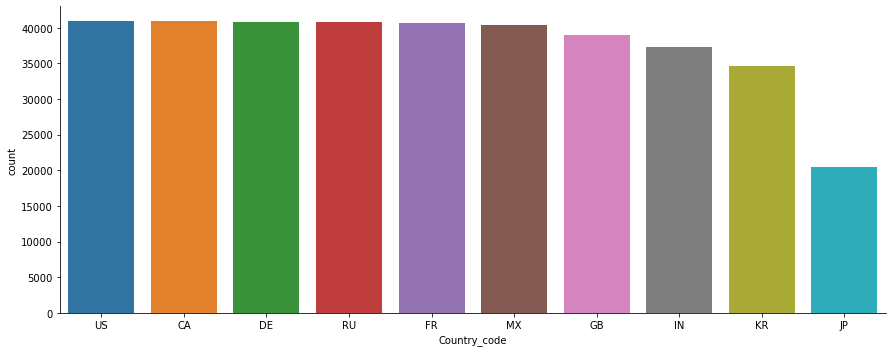

In [9]:
sns.catplot(x='Country_code', kind="count",  data=df, aspect=2.5,
            order=df['Country_code'].value_counts().index);

 Except Japan (JP) other countries have a majority position in the number of trening videos.

In [10]:
df[['Category','Country_code']].head()

,Category,Country_code
0,Howto & Style,GB
1,Entertainment,GB
2,Music,GB
3,Sports,GB
4,News & Politics,GB


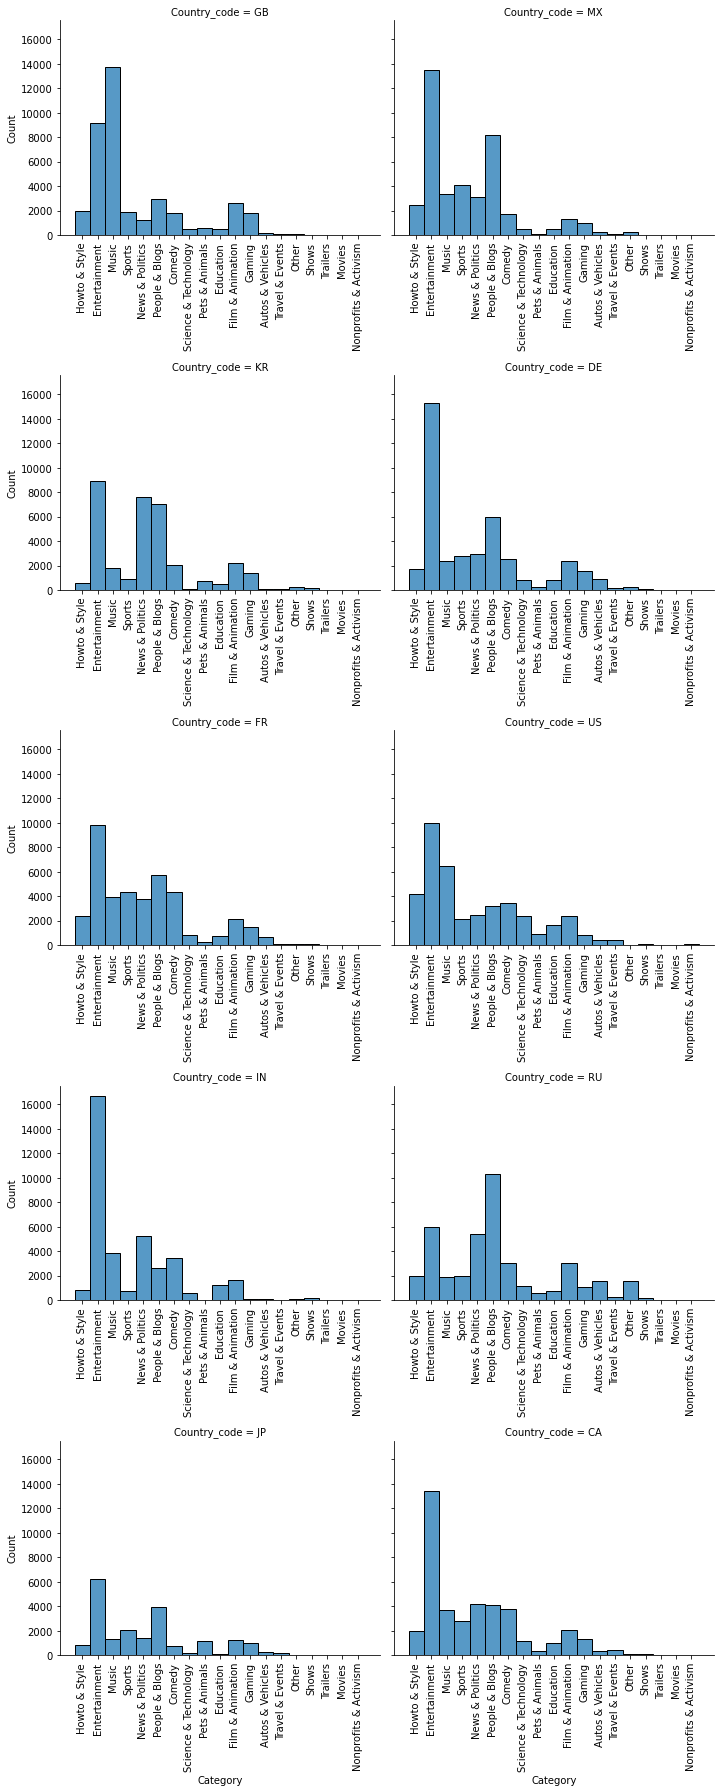

In [11]:
g = sns.FacetGrid(df, col='Country_code', height=5, aspect=1, col_wrap=2)
g.map(sns.histplot, 'Category')
g.add_legend()
g.set_xticklabels(rotation=90);
# axis titles for every sub plot
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
# shrink sub plots
g.fig.tight_layout()

# 1) Categorical differences in viewing patterns between Germans and Indians

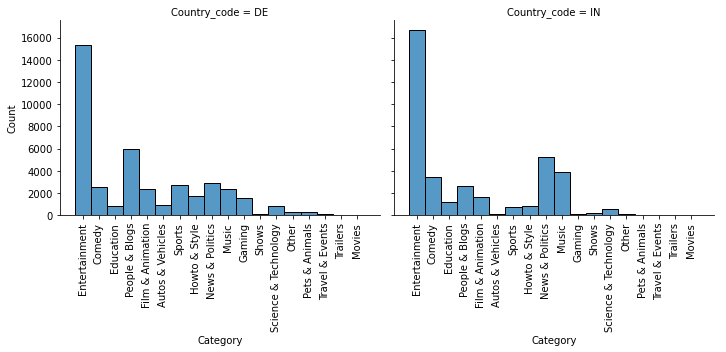

In [12]:
g = sns.FacetGrid(df[df['Country_code'].isin(['DE', 'IN'])], col='Country_code', height=5, aspect=1, col_wrap=2)
g.map(sns.histplot, 'Category')
g.add_legend()
g.set_xticklabels(rotation=90);
# axis titles for every sub plot
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
# shrink sub plots
g.fig.tight_layout()

In [13]:
countries

['GB', 'MX', 'KR', 'DE', 'FR', 'US', 'IN', 'RU', 'JP', 'CA']

In [14]:
categories = df["Category"].unique()
categories

array(['Howto & Style', 'Entertainment', 'Music', 'Sports',
       'News & Politics', 'People & Blogs', 'Comedy',
       'Science & Technology', 'Pets & Animals', 'Education',
       'Film & Animation', 'Gaming', 'Autos & Vehicles',
       'Travel & Events', 'Other', 'Shows', 'Trailers', 'Movies',
       'Nonprofits & Activism'], dtype=object)

In [15]:
categories_DE = df[df["Country_code"] == 'DE']["Category"]
categories_DE, count_DE = np.unique(categories_DE, return_counts=True)
categories_count_dict_DE = dict(zip(categories_DE, count_DE))
categories_DE, count_DE

(array(['Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
        'Film & Animation', 'Gaming', 'Howto & Style', 'Movies', 'Music',
        'News & Politics', 'Other', 'People & Blogs', 'Pets & Animals',
        'Science & Technology', 'Shows', 'Sports', 'Trailers',
        'Travel & Events'], dtype=object),
 array([  873,  2534,   844, 15292,  2376,  1565,  1745,     2,  2372,
         2935,   256,  5988,   251,   806,   107,  2752,     1,   141],
       dtype=int64))

In [16]:
categories_IN = df[df["Country_code"] == 'IN']["Category"]
categories_IN, count_IN = np.unique(categories_IN, return_counts=True)
categories_count_dict_IN = dict(zip(categories_IN, count_IN))
categories_IN, count_IN

(array(['Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
        'Film & Animation', 'Gaming', 'Howto & Style', 'Movies', 'Music',
        'News & Politics', 'Other', 'People & Blogs', 'Pets & Animals',
        'Science & Technology', 'Shows', 'Sports', 'Travel & Events'],
       dtype=object),
 array([   72,  3429,  1227, 16712,  1658,    66,   845,    16,  3858,
         5241,   105,  2624,     3,   552,   205,   731,     8],
       dtype=int64))

In [17]:
categories_count_dict_diff = {}
for category in categories:
    if categories_count_dict_DE.get(category) and categories_count_dict_IN.get(category):
        categories_count_dict_diff[category] = categories_count_dict_DE[category] - categories_count_dict_IN[category]
    elif categories_count_dict_DE.get(category) and not categories_count_dict_IN.get(category):
        categories_count_dict_diff[category] = categories_count_dict_DE[category]
    elif not categories_count_dict_DE.get(category) and categories_count_dict_IN.get(category):
        categories_count_dict_diff[category] = - categories_count_dict_IN[category]
    else:
        categories_count_dict_diff[category] = 0
        

categories_count_dict_diff = dict(sorted(categories_count_dict_diff.items(), key=lambda item: abs(item[1])))
categories_count_dict_diff

{'Nonprofits & Activism': 0,
 'Trailers': 1,
 'Movies': -14,
 'Shows': -98,
 'Travel & Events': 133,
 'Other': 151,
 'Pets & Animals': 248,
 'Science & Technology': 254,
 'Education': -383,
 'Film & Animation': 718,
 'Autos & Vehicles': 801,
 'Comedy': -895,
 'Howto & Style': 900,
 'Entertainment': -1420,
 'Music': -1486,
 'Gaming': 1499,
 'Sports': 2021,
 'News & Politics': -2306,
 'People & Blogs': 3364}

In [18]:
categories_count_dict_diff_perc = {}
for category in categories:
    if categories_count_dict_DE.get(category) and categories_count_dict_IN.get(category):
        categories_count_dict_diff_perc[category] = round((categories_count_dict_DE[category] 
                                - categories_count_dict_IN[category]) / categories_count_dict_DE[category], 2)
    elif categories_count_dict_DE.get(category) and not categories_count_dict_IN.get(category):
        categories_count_dict_diff_perc[category] = 1
    elif not categories_count_dict_DE.get(category) and categories_count_dict_IN.get(category):
        categories_count_dict_diff_perc[category] = - 1
    else:
        categories_count_dict_diff_perc[category] = 0
        

categories_count_dict_diff_perc = dict(sorted(categories_count_dict_diff_perc.items(), key=lambda item: abs(item[1])))
categories_count_dict_diff_perc

{'Nonprofits & Activism': 0,
 'Entertainment': -0.09,
 'Film & Animation': 0.3,
 'Science & Technology': 0.32,
 'Comedy': -0.35,
 'Education': -0.45,
 'Howto & Style': 0.52,
 'People & Blogs': 0.56,
 'Other': 0.59,
 'Music': -0.63,
 'Sports': 0.73,
 'News & Politics': -0.79,
 'Autos & Vehicles': 0.92,
 'Shows': -0.92,
 'Travel & Events': 0.94,
 'Gaming': 0.96,
 'Pets & Animals': 0.99,
 'Trailers': 1,
 'Movies': -7.0}

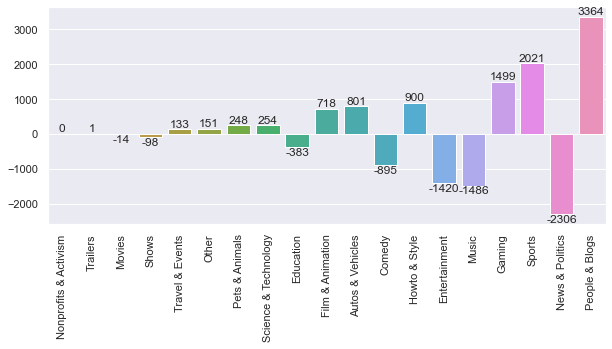

In [19]:
sns.set(rc={'figure.figsize':(10, 4)})
ax = sns.barplot(x=list(categories_count_dict_diff.keys()), 
            y=list(categories_count_dict_diff.values())
           );
plt.xticks(rotation=90);
for i in ax.containers:
    ax.bar_label(i,)

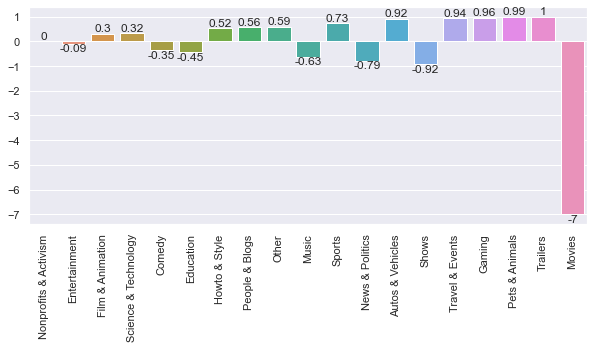

In [20]:
sns.set(rc={'figure.figsize':(10, 4)})
ax = sns.barplot(x=list(categories_count_dict_diff_perc.keys()), 
            y=list(categories_count_dict_diff_perc.values())
           );
plt.xticks(rotation=90);
for i in ax.containers:
    ax.bar_label(i,)

The biggest differen

**Попробовать посмотреть как во времени меняются тренды у немцев и индусов?**

In [21]:
df_diff = pd.DataFrame(categories_count_dict_IN, index=[0])
df_diff = pd.concat([df_diff, pd.DataFrame(categories_count_dict_DE, index=[1])])
df_diff = df_diff.T.rename({0: 'IN', 1: 'DE'}, axis='columns')
df_diff = df_diff.reset_index().rename({'index': 'Category'}, axis='columns')
df_diff.sort_values(by='IN', inplace=True)
df_diff['ratio IN / DE'] = df_diff['IN'] / df_diff['DE']
df_diff['ratio DE / IN'] = df_diff['DE'] / df_diff['IN']
#df_diff['percentage diff'] = round(df_diff['abs diff'] / df_diff['IN']
df_diff

,Category,IN,DE,ratio IN / DE,ratio DE / IN
12,Pets & Animals,3.0,251.0,0.011952,83.666667
16,Travel & Events,8.0,141.0,0.056738,17.625000
7,Movies,16.0,2.0,8.000000,0.125000
5,Gaming,66.0,1565.0,0.042173,23.712121
0,Autos & Vehicles,72.0,873.0,0.082474,12.125000
10,Other,105.0,256.0,0.410156,2.438095
14,Shows,205.0,107.0,1.915888,0.521951
13,Science & Technology,552.0,806.0,0.684864,1.460145
15,Sports,731.0,2752.0,0.265625,3.764706
6,Howto & Style,845.0,1745.0,0.484241,2.065089


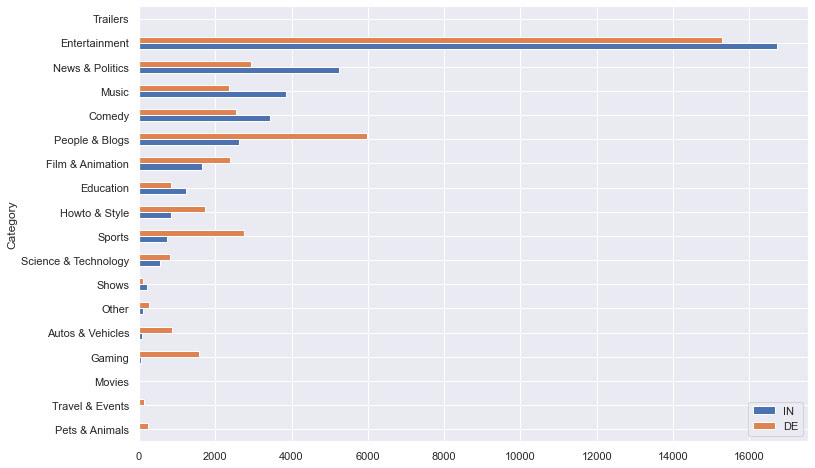

In [22]:
df_diff[['Category', 'IN', 'DE']].plot(kind='barh', x='Category', figsize=(12,8));

According to the analysis of the behaviours of Indians and German people, there are a lot of differences. It could be found out by distribution and difference in absolute and percentage ratio.
- `Pets & Animals`,  `Travel & Events`. Those categories are not the most popular for both nations, but Germans in 84 and 17 times more interested in pets, animals, travel and event
- `Gaming`, `Autos & Vehicles`. Those categories show moderate interest from both groups but as in the previous item, Germans are much more interested in gaming, autos and vehicles.
- Entertainment category. The `Entertainment` category is the most popular in both groups. It has an 8% deviation only. However, Indians and Germans trending categories are showing different patterns. For example, for Indians `News & Politics`, `Music`, ‘Comedy’ are more trendy but Germans prefer `People & Blogs`, `Film & Animation`.
- `People & Blogs` in 2.3 times trendier than in India. `Sport` is almost 3.8 times.
- `Education` and `Science & Technology` are very similar in both countries.


# 2) Ratios between views / likes / dislikes for different categories / countries. It seems to me that the Mexicans like all videos and the British are unhappy again. Is it easier for musicians to collect likes than for politicians?

In [23]:
df

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Category,Country_code,days
0,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style,GB,4
1,2017-11-14,Taylor Swift: â¦Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12 06:24:44+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs â¦Ready f...,Entertainment,GB,2
2,2017-11-14,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,Music,GB,4
3,2017-11-14,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13 02:30:38+00:00,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Sports,GB,1
4,2017-11-14,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13 01:45:13+00:00,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,News & Politics,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,2018-06-14,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13 18:00:07+00:00,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,ð¨ NEW MERCH! http://amzn.to/annoyingorange ...,Entertainment,CA,1
40877,2018-06-14,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13 19:01:18+00:00,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,âº Retrouvez vos programmes prÃ©fÃ©rÃ©s : htt...,Entertainment,CA,1
40878,2018-06-14,KINGDOM HEARTS III â SQUARE ENIX E3 SHOWCASE...,Kingdom Hearts,20,2018-06-11 17:30:53+00:00,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...,Gaming,CA,3
40879,2018-06-14,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13 04:00:05+00:00,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isnât talking so tough now. An...,News & Politics,CA,1


In [24]:
df['Country_code'].value_counts()

US    40949
CA    40881
DE    40840
RU    40739
FR    40724
MX    40451
GB    38916
IN    37352
KR    34567
JP    20523
Name: Country_code, dtype: int64

### All countries

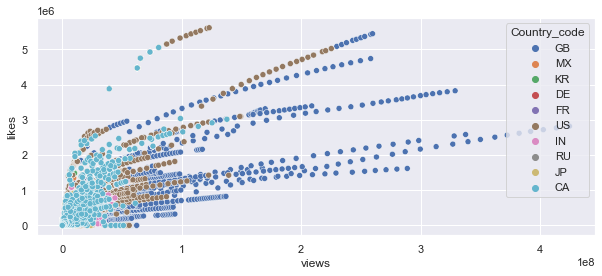

In [25]:
sns.scatterplot(data=df, x='views', y='likes', hue='Country_code');

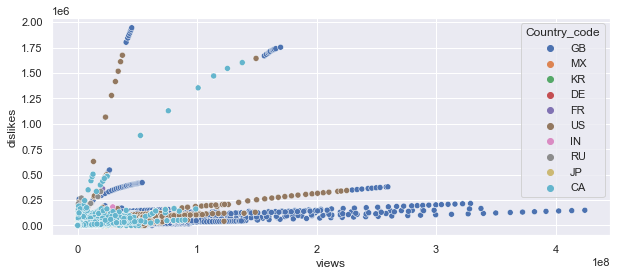

In [26]:
sns.scatterplot(data=df, x='views', y='dislikes', hue='Country_code');

### Great Britain, Mexico, Russia

### Likes

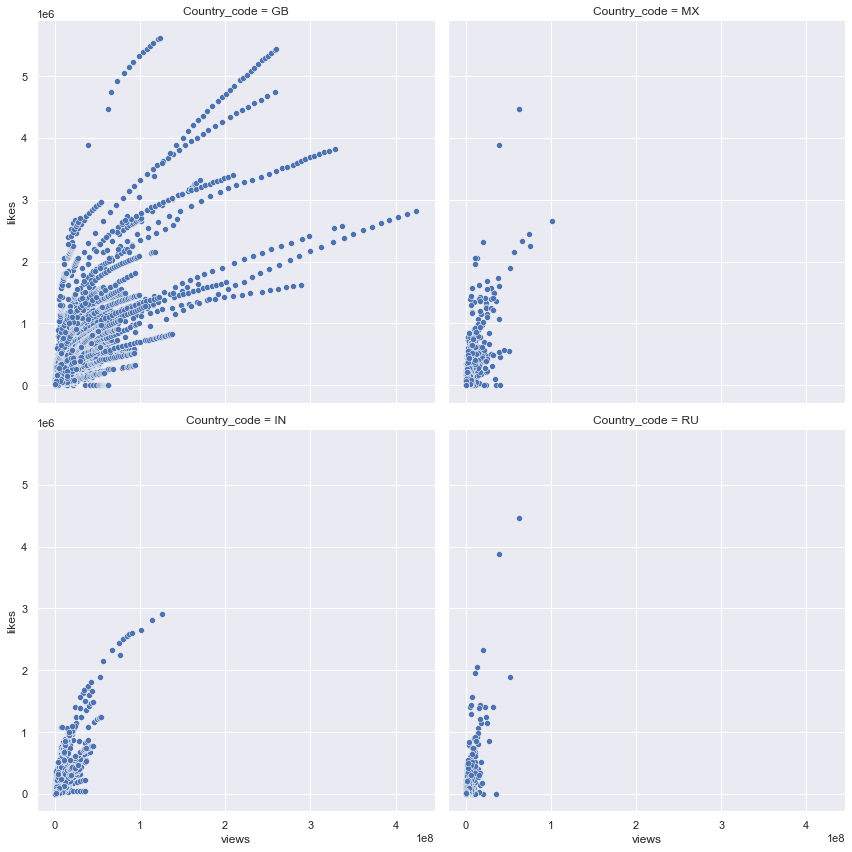

In [27]:
g = sns.FacetGrid(df[df['Country_code'].isin(['GB', 'MX', 'RU', 'IN'])], col='Country_code',
                  height=6, aspect=1, col_wrap=2)
g.map(sns.scatterplot, 'views', 'likes');
#g.set(xscale="log", yscale="log");

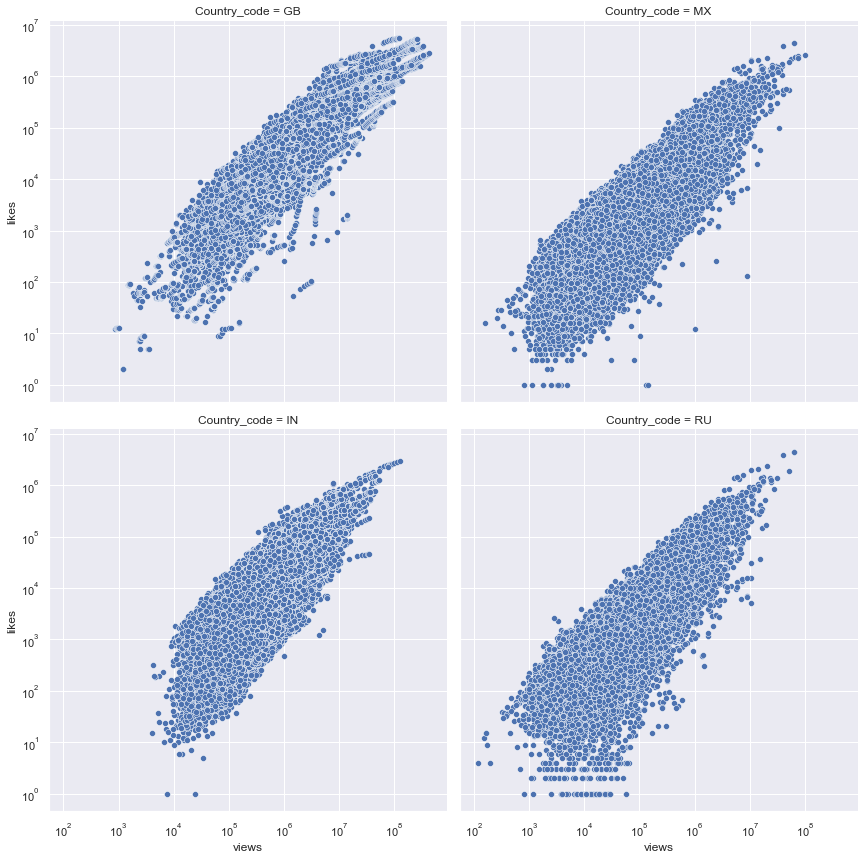

In [28]:
g = sns.FacetGrid(df[df['Country_code'].isin(['GB', 'MX', 'RU', 'IN'])], col='Country_code',
                  height=6, aspect=1, col_wrap=2)
g.map(sns.scatterplot, 'views', 'likes');
g.set(xscale="log", yscale="log");

### Dislikes

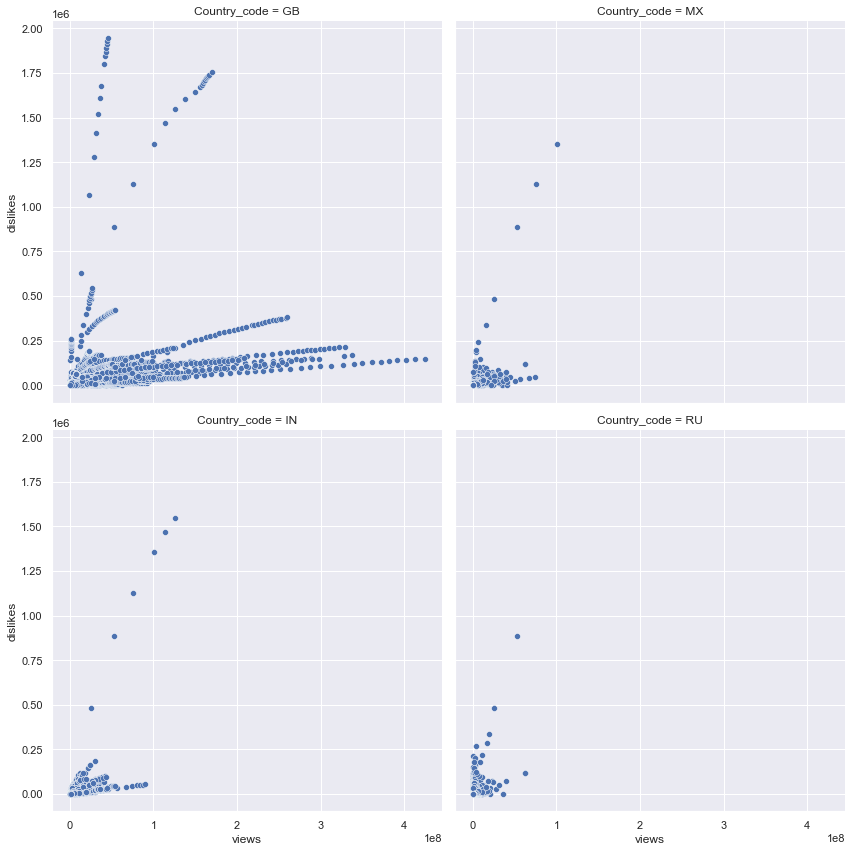

In [29]:
g = sns.FacetGrid(df[df['Country_code'].isin(['GB', 'MX', 'RU', 'IN'])], col='Country_code',
                  height=6, aspect=1, col_wrap=2)
g.map(sns.scatterplot, 'views', 'dislikes');
#g.set(xscale="log", yscale="log");

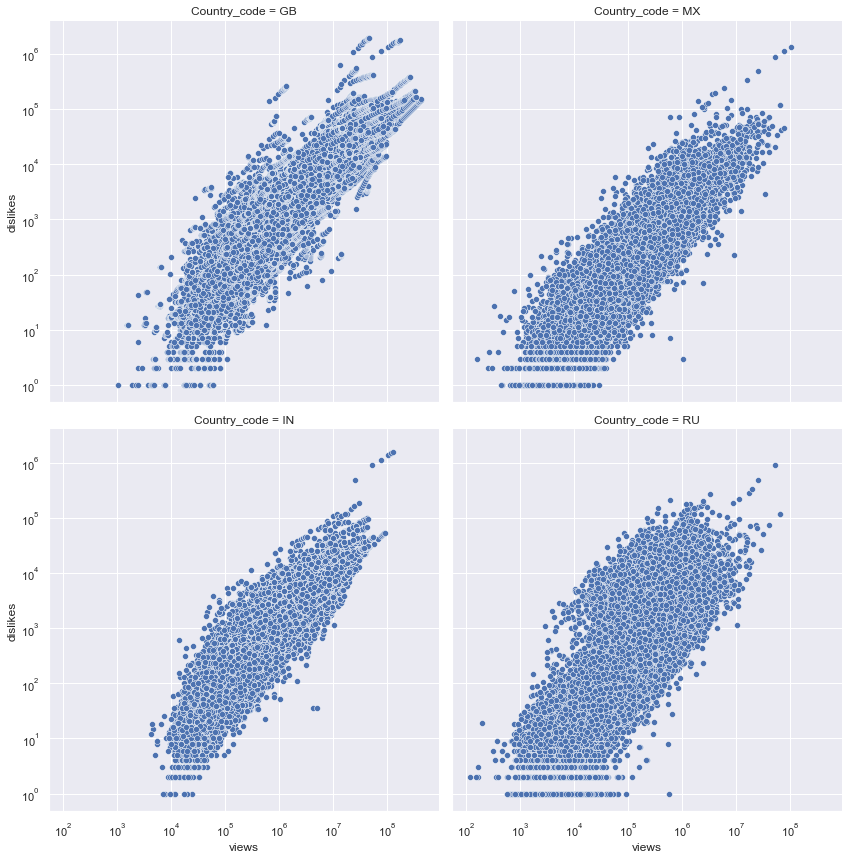

In [30]:
g = sns.FacetGrid(df[df['Country_code'].isin(['GB', 'MX', 'RU', 'IN'])], col='Country_code',
                  height=6, aspect=1, col_wrap=2)
g.map(sns.scatterplot, 'views', 'dislikes');
g.set(xscale="log", yscale="log");

### Aggregation by countries

In [31]:
df_agg = df.groupby(by='Country_code').sum()
# scaling
df_agg['comment / views ratio'] = df_agg['comment_count'] / df_agg['views']
df_agg['likes / views ratio'] = df_agg['likes'] / df_agg['views']
df_agg['dislikes / views ratio'] = df_agg['dislikes'] / df_agg['views']
df_agg = df_agg.drop(['category_id', 'video_error_or_removed'], axis=1)
df_agg.style.background_gradient(cmap='Blues')

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,days,comment / views ratio,likes / views ratio,dislikes / views ratio
Country_code,,,,,,,,,,
CA,46891975069,1618179878,82137919,206161849,583,279,142345,0.004397,0.034509,0.001752
DE,24645115205,893395538,57059031,113774380,1044,672,75571,0.004617,0.036250,0.002315
FR,17100897444,708144090,33188528,74624804,889,704,114079,0.004364,0.041410,0.001941
GB,230069198174,5234962944,296250384,509346351,683,272,1430684,0.002214,0.022754,0.001288
IN,39610961029,1011593670,62194142,99991208,1204,781,77974,0.002524,0.025538,0.001570
JP,5377466630,165406898,7528321,24547106,1414,1390,29127,0.004565,0.030759,0.001400
KR,14689152313,421247912,18634999,70011397,511,1400,91607,0.004766,0.028677,0.001269
MX,13849692994,641627186,30223385,82506287,440,634,77793,0.005957,0.046328,0.002182
RU,9806494525,506598491,60098157,72321143,1062,1007,91542,0.007375,0.051659,0.006128


**Conclusion**

**Great Britain is the least involved. GB has the lowest ratios of comments, likes and dislikes to views. In other words, GB has the lowest response. However, Russia has the highest ratio. Whereas Mexico seems to me have the 2-nd place in involvedness rating.**

### Aggregation by category and country

In [32]:
df_agg_cc = df.groupby(by=[ 'Category', 'Country_code',]).sum()
# scaling
df_agg_cc['comment / views ratio'] = df_agg_cc['comment_count'] / df_agg_cc['views']
df_agg_cc['likes / views ratio'] = df_agg_cc['likes'] / df_agg_cc['views']
df_agg_cc['dislikes / views ratio'] = df_agg_cc['dislikes'] / df_agg_cc['views']
df_agg_cc = df_agg_cc.drop(['category_id', 'comments_disabled', 'ratings_disabled',
                            'video_error_or_removed'], axis=1)
df_agg_cc.head(12)

views      likes  dislikes  comment_count  \
Category         Country_code                                                   
Autos & Vehicles CA             200066074    4732114    197776        1016188   
                 DE             182112183    6143363    182704         657163   
                 FR              43764940    1606767     52260         207973   
                 GB             214184514    3543625    281190         505085   
                 IN              30384725     539571     22284          86488   
                 JP              23293878     294124     21584          45615   
                 KR              14384059     152055     13073          40523   
                 MX              49190861    2980893     83752         368109   
                 RU             383781815   21223727   1473827        2245794   
                 US             520690717    4245656    243010         784447   
Comedy           CA            3708438785  196046674   5372515       19638776   
                 DE            1642158154   74787405   2557861        8851969   

                                days  comment / views ratio  \
Category         Country_code                                 
Autos & Vehicles CA             1363               0.005079   
                 DE             1733               0.003609   
                 FR              841               0.004752   
                 GB             7208               0.002358   
                 IN              146               0.002846   
                 JP              394               0.001958   
                 KR              253               0.002817   
                 MX              275               0.007483   
                 RU             2082               0.005852   
                 US            16591               0.001507   
Comedy           CA            22850               0.005296   
                 DE             3905               0.005390   

                               likes / views ratio  dislikes / views ratio  
Category         Country_code                                               
Autos & Vehicles CA                       0.023653                0.000989  
                 DE                       0.033734                0.001003  
                 FR                       0.036714                0.001194  
                 GB                       0.016545                0.001313  
                 IN                       0.017758                0.000733  
                 JP                       0.012627                0.000927  
                 KR                       0.010571                0.000909  
                 MX                       0.060599                0.001703  
                 RU                       0.055302                0.003840  
                 US                       0.008154                0.000467  
Comedy           CA                       0.052865                0.001449  
                 DE                       0.045542                0.001558

#### Likes distribution

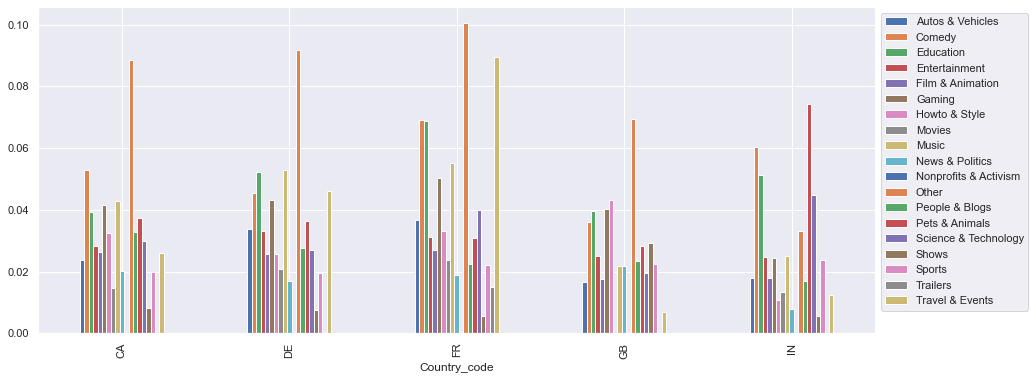

In [33]:
ax = df_agg_cc['likes / views ratio'].unstack(level=0)[:5].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

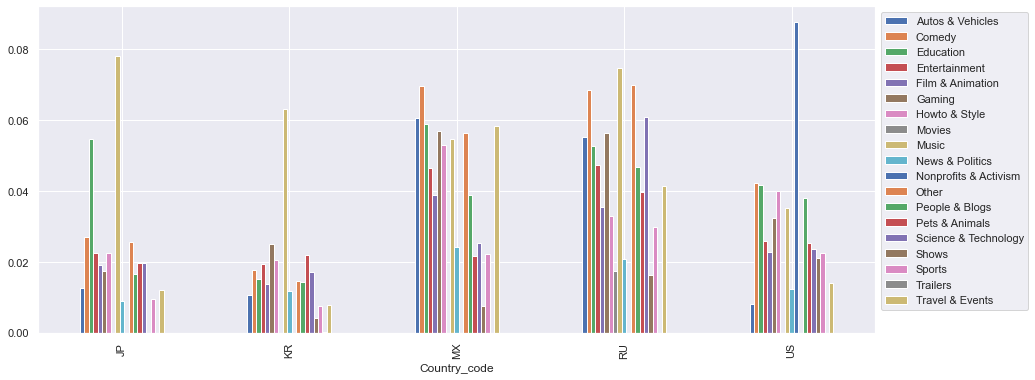

In [34]:
ax = df_agg_cc['likes / views ratio'].unstack(level=0)[5:].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

**Likes distribution shows that**:
- Category `Movies` is not in trends in GB, JP, KR, MX and US.
- `Nonprofits & Activism` I in trending video in US only but no `Movie` and `Other` category. `Trailers` is in France only.
- Japan has not `Shows`
- The most “musical” country is Japan, and the least is Great Britain.
- `Other` category is the most popular for about a half countries.

#### Dislikes distribution

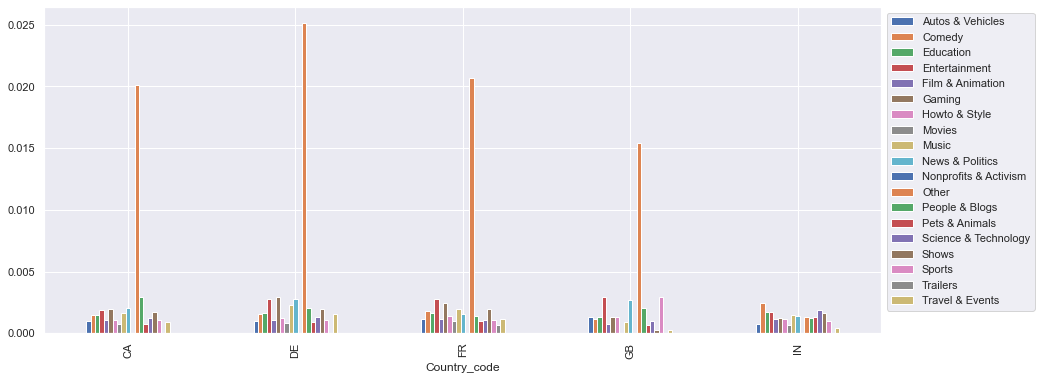

In [35]:
ax = df_agg_cc['dislikes / views ratio'].unstack(level=0)[:5].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

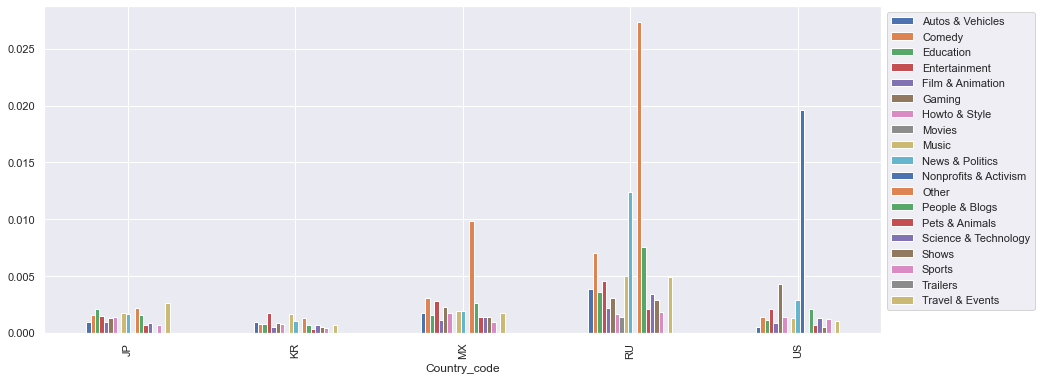

In [36]:
ax = df_agg_cc['dislikes / views ratio'].unstack(level=0)[5:].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

### Aggregation by country and category

In [37]:
df_agg_cc = df.groupby(by=['Country_code', 'Category', ]).sum()
# scaling
df_agg_cc['comment / views ratio'] = df_agg_cc['comment_count'] / df_agg_cc['views']
df_agg_cc['likes / views ratio'] = df_agg_cc['likes'] / df_agg_cc['views']
df_agg_cc['dislikes / views ratio'] = df_agg_cc['dislikes'] / df_agg_cc['views']
df_agg_cc = df_agg_cc.drop(['category_id', 'comments_disabled', 'ratings_disabled',
                            'video_error_or_removed'], axis=1)
df_agg_cc.head(20)

views      likes  dislikes  \
Country_code Category                                                 
CA           Autos & Vehicles        200066074    4732114    197776   
             Comedy                 3708438785  196046674   5372515   
             Education               531773343   20972402    793448   
             Entertainment         13671215509  387245433  25791583   
             Film & Animation       2939060844   77802003   3111259   
             Gaming                 1241532385   51726552   2446882   
             Howto & Style          1570846611   51183104   1730520   
             Movies                   17120490     252905     12280   
             Music                 13179850194  564447530  22098190   
             News & Politics        1614610043   32705054   3264041   
             Other                   115601623   10242613   2325807   
             People & Blogs         3228227926  105388564   9480796   
             Pets & Animals          235592173    8830736    185003   
             Science & Technology   1425090421   42814598   1791153   
             Shows                    71549508     589263    120436   
             Sports                 2997652188   59449419   3286369   
             Travel & Events         143746952    3750914    129861   
DE           Autos & Vehicles        182112183    6143363    182704   
             Comedy                 1642158154   74787405   2557861   
             Education               143868522    7516778    234168   

                                   comment_count   days  \
Country_code Category                                     
CA           Autos & Vehicles            1016188   1363   
             Comedy                     19638776  22850   
             Education                   2968416   3273   
             Entertainment              55313036  31694   
             Film & Animation           10086573  15959   
             Gaming                      9664887   4027   
             Howto & Style               8342917   3351   
             Movies                        13979     15   
             Music                      52435252  19237   
             News & Politics             9259788   8088   
             Other                       3222541    922   
             People & Blogs             16818201  14977   
             Pets & Animals              1823538    724   
             Science & Technology        7209219  10852   
             Shows                         77243    155   
             Sports                      7661342   4156   
             Travel & Events              609953    702   
DE           Autos & Vehicles             657163   1733   
             Comedy                      8851969   3905   
             Education                    888078   1197   

                                   comment / views ratio  likes / views ratio  \
Country_code Category                                                           
CA           Autos & Vehicles                   0.005079             0.023653   
             Comedy                             0.005296             0.052865   
             Education                          0.005582             0.039439   
             Entertainment                      0.004046             0.028326   
             Film & Animation                   0.003432             0.026472   
             Gaming                             0.007785             0.041663   
             Howto & Style                      0.005311             0.032583   
             Movies                             0.000817             0.014772   
             Music                              0.003978             0.042827   
             News & Politics                    0.005735             0.020256   
             Other                              0.027876             0.088603   
             People & Blogs                     0.005210             0.032646   
             Pets & Animals                  

#### Likes / views ratio

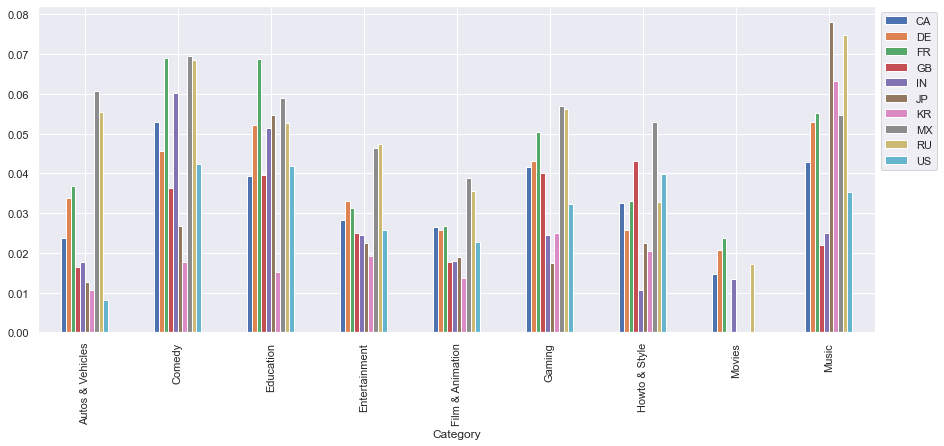

In [38]:
ax = df_agg_cc['likes / views ratio'].unstack(level=0)[:9].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

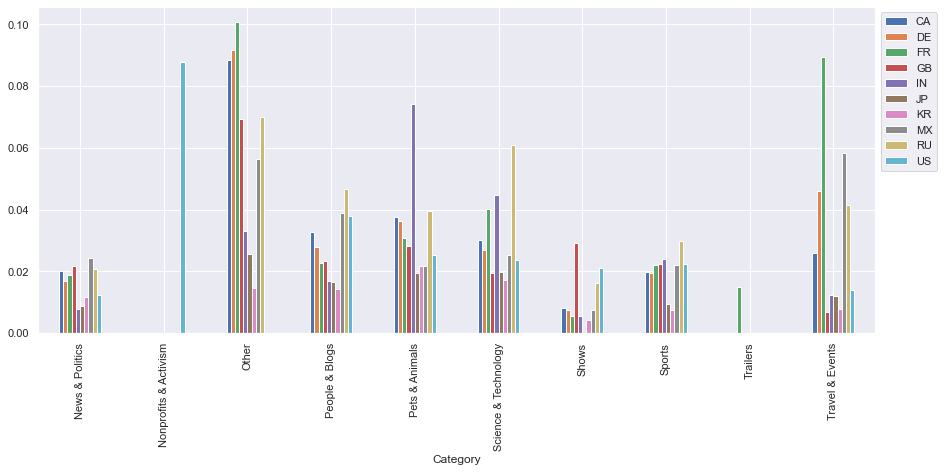

In [39]:
ax = df_agg_cc['likes / views ratio'].unstack(level=0)[9:].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

#### Dislike distribution

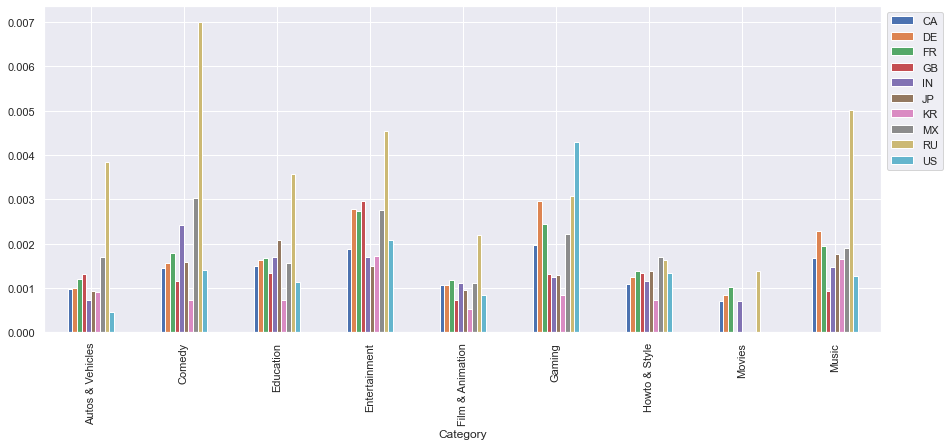

In [40]:
ax = df_agg_cc['dislikes / views ratio'].unstack(level=0)[:9].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

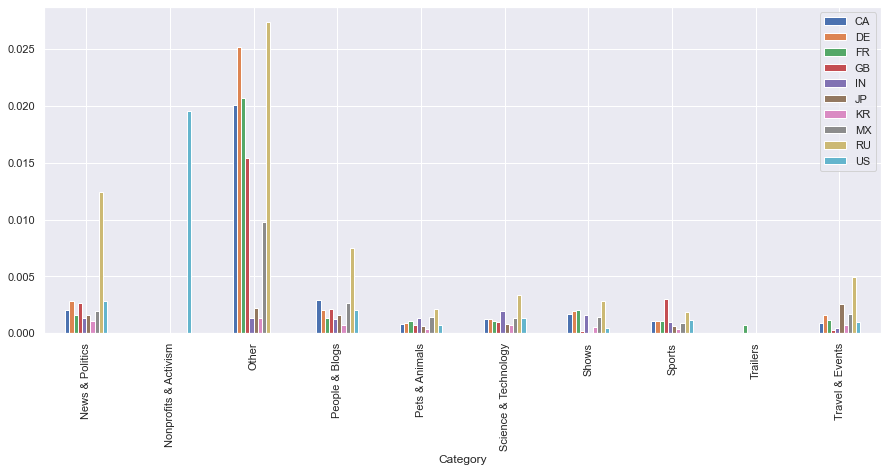

In [41]:
ax = df_agg_cc['dislikes / views ratio'].unstack(level=0)[9:].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

**Dislikes distribution shows that**:
- `Other` category has the highest dislike ratio for CA, DE, FR, GB, MX, RU.
- Russia is very involved in `News & Politics` - the dislike ratio is the 2-nd highest category.
- US has the top dislike category `Nonprofit & activism` due to the reason that US only has trending video in this category.
- It seems that Russia is the country with highest dislike ratio. RU has the most dislike among other countries in categories: `Autos & Vehicles`, `Comedy`, `Education`, `Entertainment`, `Film & Animation`, `Music`, `News & Politics`, `Other`, etc.


In [42]:
df[df['Country_code'].isin(['GB', 'MX', 'RU', 'IN'])]

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Category,Country_code,days
0,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style,GB,4
1,2017-11-14,Taylor Swift: â¦Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12 06:24:44+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs â¦Ready f...,Entertainment,GB,2
2,2017-11-14,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,Music,GB,4
3,2017-11-14,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13 02:30:38+00:00,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Sports,GB,1
4,2017-11-14,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13 01:45:13+00:00,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,News & Politics,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40734,2018-06-14,Ð£ Ð¼ÐµÐ½Ñ Ð¡ÐÐÐ! (Story booth Ð½Ð° ÑÑÑ...,Pastime Time,22,2018-06-13 13:47:01+00:00,"story booth Ð½Ð° ÑÑÑÑÐºÐ¾Ð¼|""story booth Ð...",129488,5893,164,990,https://i.ytimg.com/vi/OMmR9THjVKM/default.jpg,False,False,False,ÐÐ¾ÑÐ¸ÐºÐ¸ Ð² Blade and Soul - https://bit.l...,People & Blogs,RU,1
40735,2018-06-14,ÐÐ¾Ð¸ ÐÐµÑÑÐºÐ¸Ðµ Ð¢ÑÐ°Ð²Ð¼Ñ 2 (Ð°Ð½Ð¸Ð¼...,CaGArt,23,2018-06-12 09:38:38+00:00,"ÐºÐ°Ð³Ð°ÑÑ|""ÐºÐ°Ð³Ð¸""|""ÑÐ°Ð³Ð°ÑÑ""|""Ð³Ð°Ð³...",99163,4659,337,692,https://i.ytimg.com/vi/tX7p7NtNVDE/default.jpg,False,False,False,ÐÐ¾Ð¸ ÐÐµÑÑÐºÐ¸Ðµ Ð¢ÑÐ°Ð²Ð¼Ñ 2 (Ð°Ð½Ð¸Ð¼...,Comedy,RU,2
40736,2018-06-14,[ENG SUB] BTS PROM PARTY 2018 Intro + 2nd Gran...,DaisyxBTS 07,24,2018-06-13 12:51:23+00:00,[none],449611,24808,93,974,https://i.ytimg.com/vi/KAyj5Xm1C64/default.jpg,False,False,False,***I do NOT own anything. Just want to share t...,Entertainment,RU,1
40737,2018-06-14,ÐÐÐÐÐ ÐÐÐÐÐÐ ÐÐÐÐÐÐ¢Ð«ð/Ð¢Ð...,ÐÑÑÑÐ° ÐÐµÐ±ÐµÐ´ÐµÐ²Ð°,22,2018-06-13 00:23:33+00:00,"ÑÑÐ¼ ÑÑÑ Ð²Ð°Ð½Ð½Ð¾Ð¹ ÐºÐ¾Ð¼Ð½Ð°ÑÑ|""roo...",14225,793,39,209,https://i.ytimg.com/vi/4PiSLIrsSiY/default.jpg,False,False,False,"ÐÐ±Ð·Ð¾Ñ Ð²Ð°Ð½Ð½Ð¾Ð¹ ÐºÐ¾Ð¼Ð½Ð°ÑÑ, ÑÑÐ°...",People & Blogs,RU,1


In [43]:
df_agg_cc

views      likes  dislikes  \
Country_code Category                                                 
CA           Autos & Vehicles        200066074    4732114    197776   
             Comedy                 3708438785  196046674   5372515   
             Education               531773343   20972402    793448   
             Entertainment         13671215509  387245433  25791583   
             Film & Animation       2939060844   77802003   3111259   
...                                        ...        ...       ...   
US           Pets & Animals          764651989   19370702    527379   
             Science & Technology   3487756816   82532638   4548402   
             Shows                    51501058    1082639     24508   
             Sports                 4404456673   98621211   5133551   
             Travel & Events         343557084    4836246    340427   

                                   comment_count   days  \
Country_code Category                                     
CA           Autos & Vehicles            1016188   1363   
             Comedy                     19638776  22850   
             Education                   2968416   3273   
             Entertainment              55313036  31694   
             Film & Animation           10086573  15959   
...                                          ...    ...   
US           Pets & Animals              2660705   7111   
             Science & Technology       11989926  43612   
             Shows                         95117    611   
             Sports                     11192155  50996   
             Travel & Events              911511   2837   

                                   comment / views ratio  likes / views ratio  \
Country_code Category                                                           
CA           Autos & Vehicles                   0.005079             0.023653   
             Comedy                             0.005296             0.052865   
             Education                          0.005582             0.039439   
             Entertainment                      0.004046             0.028326   
             Film & Animation                   0.003432             0.026472   
...                                                  ...                  ...   
US           Pets & Animals                     0.003480             0.025333   
             Science & Technology               0.003438             0.023664   
             Shows                              0.001847             0.021022   
             Sports                             0.002541             0.022391   
             Travel & Events                    0.002653             0.014077   

                                   dislikes / views ratio  
Country_code Category                                      
CA           Autos & Vehicles                    0.000989  
             Comedy                              0.001449  
             Education                           0.001492  
             Entertainment                       0.001887  
             Film & Animation                    0.001059  
...                                                   ...  
US           Pets & Animals                      0.000690  
             Science & Technology                0.001304  
             Shows                               0.000476  
             Sports                              0.001166  
             Travel & Events                     0.000991  

[167 rows x 8 columns]

## Is it easier for musicians to collect likes than for politicians?

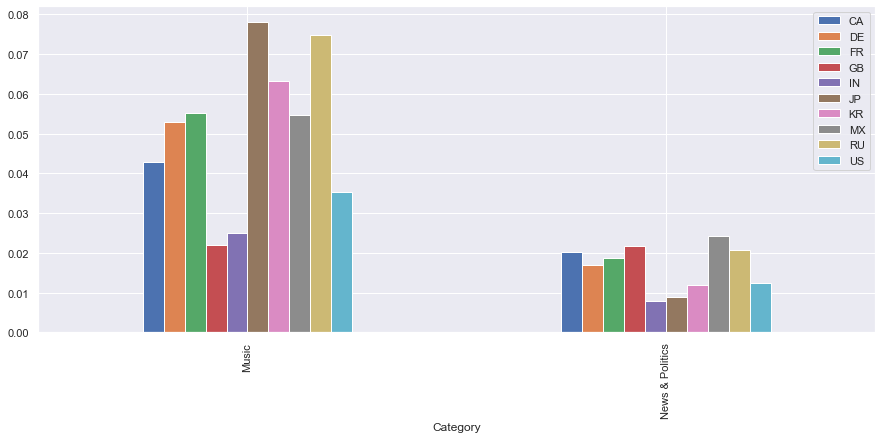

In [44]:
ax = df_agg_cc[np.in1d(df_agg_cc.index.get_level_values(1), ['Music', 'News & Politics'])]['likes / views ratio'].unstack(level=0)[:9].plot(kind='bar', subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));

**Yes, Is it easier for musicians to collect likes than for politicians. `Music` category has more likes then `News & Politics` for all countries.**

## 3) Сhannels that are popular in most countries. Ed Sheeran, hello.

### Сhannels that are popular in total

In [45]:
df.sample(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Category,Country_code,days
32171,2018-06-01,[ì¼ì][2] ë¼ì¥ìì  ì ìë ì·ë¤ ë¼ì...,ë¨¸ë ë°©ì¡,20,2018-05-31 07:18:22+00:00,"ë¨¸ë |""ajehr""|""ë¨¸ë ë°©ì¡""|""DP""|""ìì´ì""...",15449,218,6,77,https://i.ytimg.com/vi/aAuh1Wl94B0/default.jpg,False,False,False,ë¨¸ë ì±ë êµ¬ë !! ì¢ìì!!ë¨¸ë ìë°...,Gaming,KR,1
38427,2018-06-12,SPIDER-MAN: INTO THE SPIDER-VERSE - Official T...,Sony Pictures Entertainment,24,2018-06-06 13:00:04+00:00,"Shameik Moore|""Hailee Steinfeld""|""Mahershala A...",20771856,440493,20324,44778,https://i.ytimg.com/vi/g4Hbz2jLxvQ/default.jpg,False,False,False,What makes you different is what makes you Spi...,Entertainment,GB,6
13293,2018-01-21,SAFARI GO S2 avec Carole Rousseau sur Gulli ! ...,Gulli,24,2018-01-19 21:26:19+00:00,"gulli""|""gulli tv""|""disney channel""|""canal J""|""...",9412,123,6,15,https://i.ytimg.com/vi/gc0MOkS5bW0/default.jpg,False,False,False,Le moment est venu pour les Jaunes et les Vert...,Entertainment,FR,2
22165,2018-03-17,à°°à±à°ªà± à°¶à°¨à°¿ à° à°®à°¾à°µà°¾à°¸à±à°...,Telugu World visite,27,2018-03-16 04:21:42+00:00,"telugu world visite|""telugu""|""Shani Amavasya 2...",379993,2653,318,70,https://i.ytimg.com/vi/5xdAGZgwwFM/default.jpg,False,False,False,à°°à±à°ªà± à°¶à°¨à°¿ à° à°®à°¾à°µà°¾à°¸à±à°...,Education,IN,1
16375,2018-02-05,2 Card Slay the Spire Run - Consistent Turn 1 ...,RiskyCB,20,2018-01-25 02:46:48+00:00,"Slay the Spire|""RiskyCB""|""2 card deck""|""infini...",161668,1954,79,163,https://i.ytimg.com/vi/jrkhLuroyzg/default.jpg,False,False,False,This run was sweet. I could have optimized the...,Gaming,GB,11


In [46]:
df_agg_pop = df.groupby(by='channel_title').sum()
# scaling
# df_agg_pop['comment / views ratio'] = df_agg_pop['comment_count'] / df_agg_pop['views']
# df_agg_pop['likes / views ratio'] = df_agg_pop['likes'] / df_agg_pop['views']
# df_agg_pop['dislikes / views ratio'] = df_agg_pop['dislikes'] / df_agg_pop['views']
df_agg_pop = df_agg_pop.drop(['category_id', 'comments_disabled', 'ratings_disabled',
                            'video_error_or_removed'], axis=1)
df_agg_pop.sort_values(by='views', ascending=False).head(10)

,views,likes,dislikes,comment_count,days
channel_title,,,,,
ChildishGambinoVEVO,11016766510,290475817,17573340,30377922,1114
Marvel Entertainment,10430605449,311432064,6051321,37138547,3107
NickyJamTV,9479859505,83991590,5436657,4855300,1079
Ozuna,8623329509,81782583,5199598,3558108,1460
ibighit,8205572221,776812043,12826623,125065899,2067
DrakeVEVO,7637228580,194303287,4124497,12272779,1552
Bad Bunny,7124207494,120656888,5741216,7059451,693
ArianaGrandeVevo,6202230488,185568800,6995930,15745293,1118
jypentertainment,5802822913,173091543,9756105,28009778,2581


**`Ed Sheeran` with 5.8 billion of views at 10-th position, whereas `ChildishGambinoVEVO` has 11 billion.**

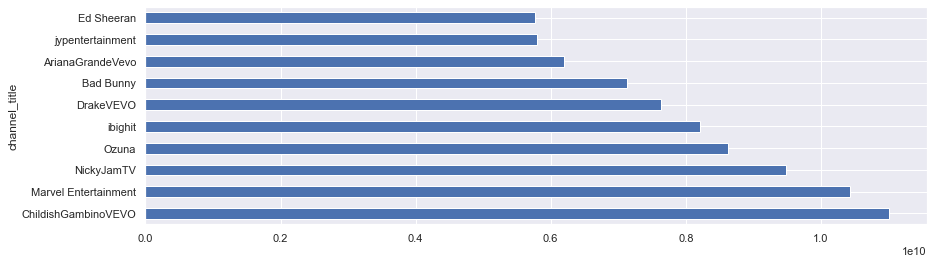

In [47]:
ax = df_agg_pop.sort_values(by='views', ascending=False)['views'][:10].plot(kind='barh',
                                                        subplots=False, figsize=(14,4));

**If popularity measure by other metrics, picture will be different. For example, `by likes` Ed Sheeran at 6-th place.**

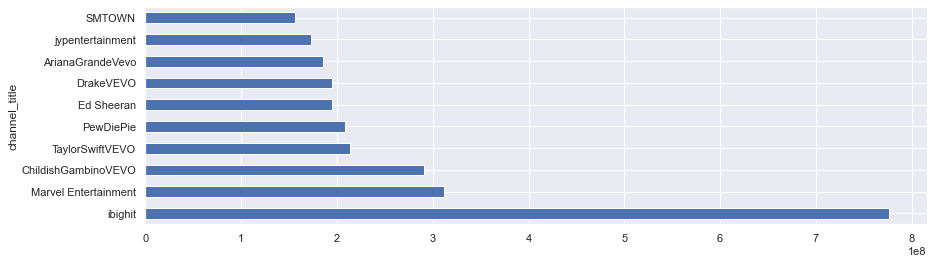

In [48]:
ax = df_agg_pop.sort_values(by='likes', ascending=False)['likes'][:10].plot(kind='barh',
                                                        subplots=False, figsize=(14,4));

**By `comment_count` he is at 15-th place.**

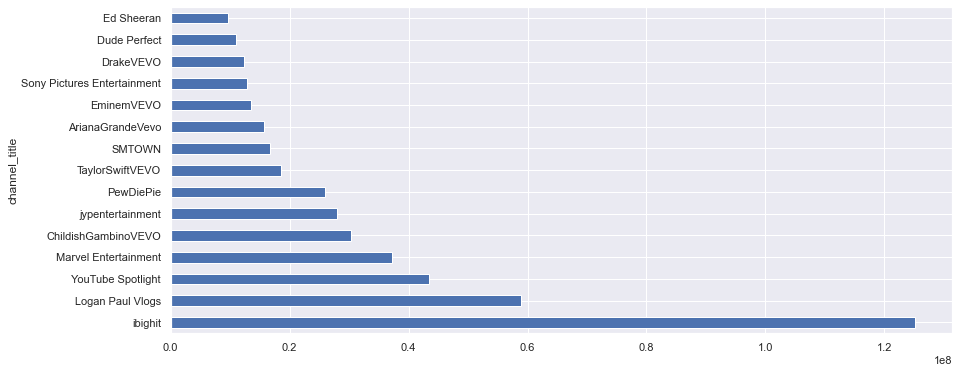

In [49]:
ax = df_agg_pop.sort_values(by='comment_count', ascending=False)['comment_count'][:15].plot(kind='barh',
                                                        subplots=False, figsize=(14,6));

### Сhannels that are popular by countries

In [50]:
df_agg_pop_cc = df.groupby(by=[ 'channel_title', 'Country_code',]).sum()
# scaling
# df_agg_pop_cc['comment / views ratio'] = df_agg_pop_cc['comment_count'] / df_agg_pop_cc['views']
# df_agg_pop_cc['likes / views ratio'] = df_agg_pop_cc['likes'] / df_agg_pop_cc['views']
# df_agg_pop_cc['dislikes / views ratio'] = df_agg_pop_cc['dislikes'] / df_agg_pop_cc['views']
# df_agg_pop_cc = df_agg_pop_cc.drop(['category_id', 'comments_disabled', 'ratings_disabled',
#                             'video_error_or_removed'], axis=1)
df_agg_pop_cc.sort_values(by='views', ascending=False)

,,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,days
channel_title,Country_code,,,,,,,,,
NickyJamTV,GB,560,8516190092,65854585,3771823,2947640,0,0,0,862
Ozuna,GB,850,8305198063,71585436,4743926,2985745,0,0,0,1394
Bad Bunny,GB,360,6891280759,106452827,5256551,6127443,0,0,0,666
DrakeVEVO,GB,620,6581834413,148133996,3429228,9225778,0,0,0,1301
ChildishGambinoVEVO,GB,360,6101309613,148408057,9558340,15441941,0,0,0,667
...,...,...,...,...,...,...,...,...,...,...
NavylittleMonster,FR,24,365,43,2,14,0,0,0,0
Videostendencias,MX,22,302,29,2,1,0,0,0,1
No Comment TV,FR,25,284,3,0,0,0,0,0,1


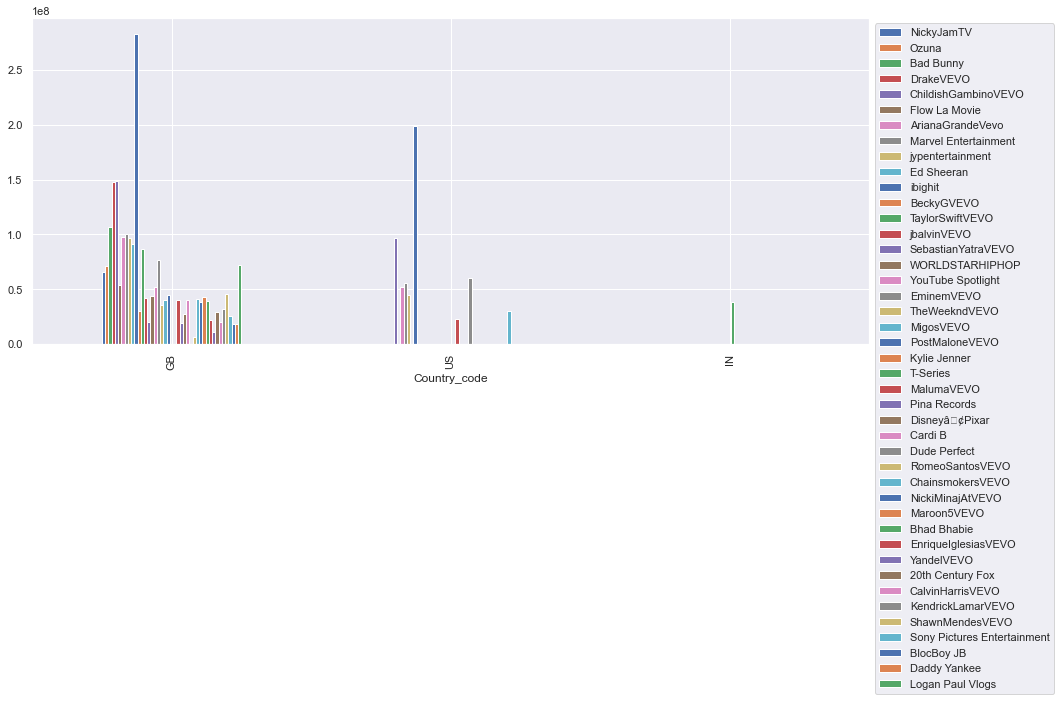

In [51]:
ax = df_agg_pop_cc.sort_values(by='views', ascending=False)[:50]['likes'].unstack(level=0).plot(kind='bar',
                                                                            subplots=False, figsize=(15,6))
ax.legend(bbox_to_anchor=(1.0, 1.0));